### Running JAX Grid Search on a single device

<a href="https://colab.research.google.com/github/ASKabalan/jax-grid-search/blob/main/exemples/01-SingleDevice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from jax_grid_search import DistributedGridSearch

### Defining the Objective Function
The objective function is evaluated for each combination of input parameters. It calculates a scalar `value` based on the given mathematical formula.

### Performing the Grid Search
The `DistributedGridSearch` class is used to systematically evaluate the objective function over a predefined search space. Each parameter in the search space is assigned a set of potential values, and the grid search explores all possible combinations.

### Running the Grid Search
The grid search iterates over the search space in batches, evaluating the objective function for each combination of parameters.

In [3]:
def objective_function(x , y , z , w):
    value =  x**2 + y**2 + z**2 - w**2
    value = value.sum()
    return {"value": value}

search_space = {"x": jnp.arange(2*2).reshape(2,2),
                "y": jnp.arange(2*2).reshape(2,2),
                "z": jnp.arange(2*2).reshape(2,2),
                "w": jnp.arange(2*2).reshape(2,2),
}


grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=8, progress_bar=True, log_every=0.1
)


grid_search.run()

Selecting batch size of 8


Processing batches: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


### Saving Results
During the execution of the grid search, the `.run()` method saves the results of each processed batch into individual `.pkl` files inside the `results` folder. This ensures that intermediate data is preserved and can be accessed later.

In [4]:
import glob

results_folder = "results"
result_files = glob.glob(f"{results_folder}/*.pkl")
print("Result files:", result_files)


Result files: ['results/result_batch_0_rank_0.pkl', 'results/result_batch_1_rank_0.pkl']


### Stacking Results
After all batches are processed and saved as `.pkl` files, you can stack the results into a single dictionary for further analysis. This is done using the `.stack_results()` method, which combines the data from all saved files in the specified folder.

In [5]:
results = grid_search.stack_results('results')

### Resuming and Continuing Grid Search
You can resume a previous grid search by using the results from earlier runs. Pass the `old_results` parameter when initializing `DistributedGridSearch` to exclude already processed combinations from the search.

The total number of combinations remaining can be determined using `len(grid_search.combinations)`.

In [6]:
print(f"number of combinations before: {len(grid_search.combinations)}")
search_space = {"x": jnp.arange(3*2).reshape(3,2),
                "y": jnp.arange(3*2).reshape(3,2),
                "z": jnp.arange(2*2).reshape(2,2),
                "w": jnp.arange(2*2).reshape(2,2),
}

grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=8, progress_bar=True, log_every=0.1
)

print(f"number of combinations after adding more to search space: {len(grid_search.combinations)}")

grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=8, progress_bar=True, log_every=0.1 , old_results=results
)

print(f"number of combinations after filtering out old results: {len(grid_search.combinations)}")


number of combinations before: 16
Selecting batch size of 6
number of combinations after adding more to search space: 36
Selecting batch size of 5
number of combinations after filtering out old results: 20


### Resuming the Grid Search
When resuming the grid search, the `DistributedGridSearch` automatically filters out combinations already processed using `old_results`. 

In this example:
- Only 20 combinations remain to be evaluated.
- The `batch_size` is adjusted from 8 to 5 to ensure it divides the remaining combinations evenly.

If we attempt to resume the search after completing these 20 combinations, the number of remaining combinations will be 0, and no further processing will occur.

In [8]:
grid_search.run()
full_results = grid_search.stack_results('results')

grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=8, progress_bar=True, log_every=0.1 , old_results=full_results
)

print(f"number of combinations after filtering out old results: {len(grid_search.combinations)}")

Processing batches:   0%|          | 0/4 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 4/4 [00:00<00:00, 38.68it/s]

Selecting batch size of 0
number of combinations after filtering out old results: 0


### Visualizing Results
To analyze the results, we start by fixing specific values for `w`, `z`, and `y`. This allows us to study the relationship between `x` and the corresponding `value` when other parameters are held constant. 

The filtered data is then plotted, with `x` on the x-axis and `value` on the y-axis, giving a clear view of how `x` influences the objective function under these conditions.

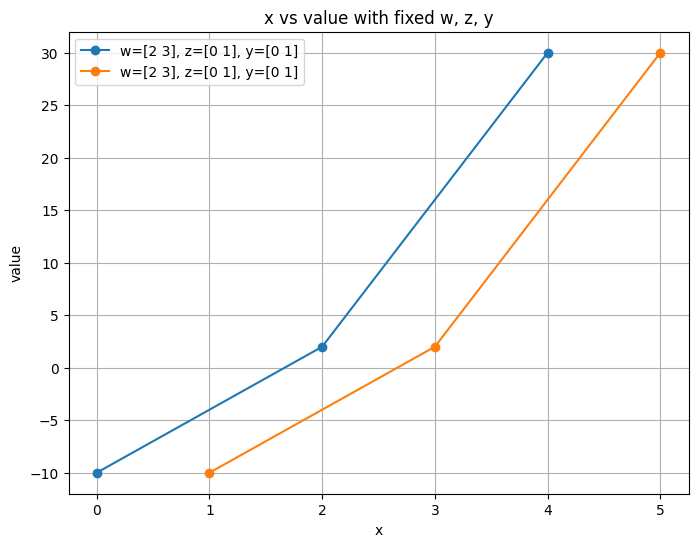

In [11]:
import matplotlib.pyplot as plt
results = grid_search.stack_results('results')

# Define fixed values for w, z, and y
fixed_w = results["w"][0]  # Take the first value of w
fixed_z = results["z"][0]  # Take the first value of z
fixed_y = results["y"][0]  # Take the first value of y

# Filter the results to match the fixed values
mask = (
    (results["w"] == fixed_w).all(axis=1) &
    (results["z"] == fixed_z).all(axis=1) &
    (results["y"] == fixed_y).all(axis=1)
)

# Extract x and value for the filtered results
filtered_x = results["x"][mask]
filtered_values = results["value"][mask]

# Plot x against value
plt.figure(figsize=(8, 6))
plt.plot(filtered_x, filtered_values, 'o-', label=f'w={fixed_w}, z={fixed_z}, y={fixed_y}')
plt.xlabel('x')
plt.ylabel('value')
plt.title('x vs value with fixed w, z, y')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
!rm -r results

/home/wassim/micromamba/envs/fg/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Logging Additional Metrics
In the `objective_function`, you can compute and return additional values beyond the primary objective. For example, here the auxiliary value (`aux_val`) is calculated as `x + y^2`.

After running the grid search, these auxiliary values are accessible in the results. You can log and validate them to ensure correctness. 

In this example:
- The first combination's `aux_val` is printed.
- It is explicitly broken down into its components: \( x + y^2 \), demonstrating that other metrics can also be logged for deeper analysis.

In [ ]:
def objective_function(x , y , z , w):
    value =  x**2 + y**2 + z**2 - w**2
    value = value.sum()
    return {"value": value , "aux_val" : x + y**2}

search_space = {"x": jnp.arange(2*2).reshape(2,2),
                "y": jnp.arange(2*2).reshape(2,2),
                "z": jnp.arange(2*2).reshape(2,2),
                "w": jnp.arange(2*2).reshape(2,2),
}


grid_search = DistributedGridSearch(
    objective_function, search_space, batch_size=8, progress_bar=True, log_every=0.1
)


grid_search.run()
results = grid_search.stack_results('results')


print(f"Aux value for the first combination: aux_val = res{results['aux_val'][0]} \nx + y^2 = {results['x'][0]} + {results['y'][0]}^2 = {results['aux_val'][0]}")

Selecting batch size of 8


Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 2/2 [00:00<00:00, 18.96it/s]

Aux value for the first combination: aux_val = res[0 2] 
x + y^2 = [0 1] + [0 1]^2 = [0 2]


: 